In [1]:
import tweepy 
import configparser
import requests     # For saving access tokens and for file management when creating and adding to the dataset
import os           # For dealing with json responses we receive from the API
import json         # For displaying the data after
import pandas as pd # For saving the response data in CSV format
import csv          # For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata  #To add wait time between requests
import time
import sqlite3
import re
from functools import partial
from collections import Counter
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
#read configs
config = configparser.ConfigParser()
config.read('config.ini')

api_key             = config['twitter']['api_key']
api_key_secret      = config['twitter']['api_key_secret']

access_token        = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

bearer_token        = config['twitter']['bearer_token']

In [3]:
#Authenticate our account with the Twitter API
auth    = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api     = tweepy.API(auth, wait_on_rate_limit=True)
    
# You can authenticate as your app with just your bearer token
client  = tweepy.Client(bearer_token=bearer_token)

# If the authentication was successful, this should print the
# screen name / username of the account
print(api.verify_credentials().screen_name)

KLuthra_


In [4]:
# Set up SQLite database
conn = sqlite3.connect('twitter_data.db')
c = conn.cursor()

In [5]:
# Create table for tweet data
c.execute('''CREATE TABLE IF NOT EXISTS tweets
             (tweet_id INTEGER PRIMARY KEY,
              author_id INTEGER,
              created_at TIMESTAMP,
              text TEXT,
              tweet_metrics JSON,
              entities JSON,
              context JSON,
              place_id JSON,
              FOREIGN KEY (author_id) REFERENCES users(author_id),
              FOREIGN KEY (place_id) REFERENCES users(place_id))''')

In [6]:
# Create table for user data
c.execute('''CREATE TABLE IF NOT EXISTS users
             (author_id INTEGER PRIMARY KEY,
              username TEXT,
              verified TEXT,
              bio TEXT,
              author_created TIMESTAMP,
              author_location TEXT,
              followers_count INTEGER,
              following_count INTEGER,
              tweet_count INTEGER,
              entities JSON,
              FOREIGN KEY (author_id) REFERENCES tweets(author_id))''')

In [18]:
c.execute("PRAGMA table_info(tweets)")
columns = c.fetchall()

for column in columns:
    print(column[1], "-", column[2])

c.execute("SELECT COUNT(DISTINCT tweet_id) FROM tweets")
row_count = c.fetchone()[0]
print(f"Number of rows in 'tweets' table: {row_count}\n")


c.execute("PRAGMA table_info(users)")
columns = c.fetchall()

for column in columns:
    print(column[1], "-", column[2])

c.execute("SELECT COUNT(DISTINCT author_id) FROM users")
row_count = c.fetchone()[0]
print(f"Number of rows in 'users' table: {row_count}\n")

tweet_id - INTEGER
author_id - INTEGER
created_at - TIMESTAMP
text - TEXT
tweet_metrics - JSON
entities - JSON
context - JSON
place_id - JSON
Number of rows in 'tweets' table: 36370

author_id - INTEGER
username - TEXT
verified - TEXT
bio - TEXT
author_created - TIMESTAMP
author_location - TEXT
followers_count - INTEGER
following_count - INTEGER
tweet_count - INTEGER
entities - JSON
Number of rows in 'users' table: 0



In [13]:
# Retrieve the data from the SQLite database
query = "SELECT * FROM tweets"
tweets_df = pd.read_sql_query(query, conn, parse_dates=['created_at'])
print(tweets_df.dtypes)


# Retrieve the data from the SQLite database
query = "SELECT * FROM users"
users_df = pd.read_sql_query(query, conn, parse_dates=['author_created'])
print(users_df.dtypes)

tweet_id                  int64
author_id                 int64
created_at       datetime64[ns]
text                     object
tweet_metrics            object
entities                 object
context                  object
place_id                 object
dtype: object
author_id          object
username           object
verified           object
bio                object
author_created     object
author_location    object
followers_count    object
following_count    object
tweet_count        object
entities           object
dtype: object


In [9]:
#Aggregated based on domain ID and take a count of all tweet IDs for each group
subset_df = tweets_df[['tweet_id', 'author_id', 'tweet_metrics', 'context', 'entities']]

subset_context_items = []
for index, row in subset_df.iterrows():
    context_list = json.loads(row['context'])
    tweet_id     = row['tweet_id']
    author_id    = row['author_id']
    for item in context_list:
        domain_id   = item['domain']['id']
        domain_name = item['domain']['name']
        entity_id   = item['entity']['id']
        entity_name = item['entity']['name']
        data = {'tweet_id': tweet_id, 'author_id': author_id, 'domain_id':domain_id, 'domain_name': domain_name, 'entity_id':entity_id, 'entity_name': entity_name}
        subset_context_items.append(data)

subset_context_item_df = pd.DataFrame(subset_context_items)

In [10]:
subset_domain_agg = subset_context_item_df.groupby(by=["domain_name"]).agg({'tweet_id': pd.Series.nunique}).reset_index().sort_values(by='tweet_id', ascending=False)
top_20_domain_counts = subset_domain_agg.head(20)

subset_domain_entity_agg = subset_context_item_df.groupby(by=["entity_name"]).agg({'tweet_id': pd.Series.nunique}).reset_index().sort_values(by='tweet_id', ascending=False)
top_50_entity_counts = subset_domain_entity_agg.head(50)

In [ ]:
subset_entity_items = []
for index, row in subset_df.iterrows():
    entity_list = json.loads(row['entities'])
    tweet_id     = row['tweet_id']
    for item in entity_list:
        entity_id   = item['annotations']['type']
        entity_name = item['annotation']['normalized_test']
        data = {'tweet_id': tweet_id, 'entity_id':entity_id, 'entity_name': entity_name}
        subset_entity_items.append(data)

subset_entity_item_df = pd.DataFrame(subset_context_items)

In [ ]:
##WHAT IS THE DISTRIBUTIION OF TWEETS PER USER

<ipython-input-11-a7b77481d26e>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60)


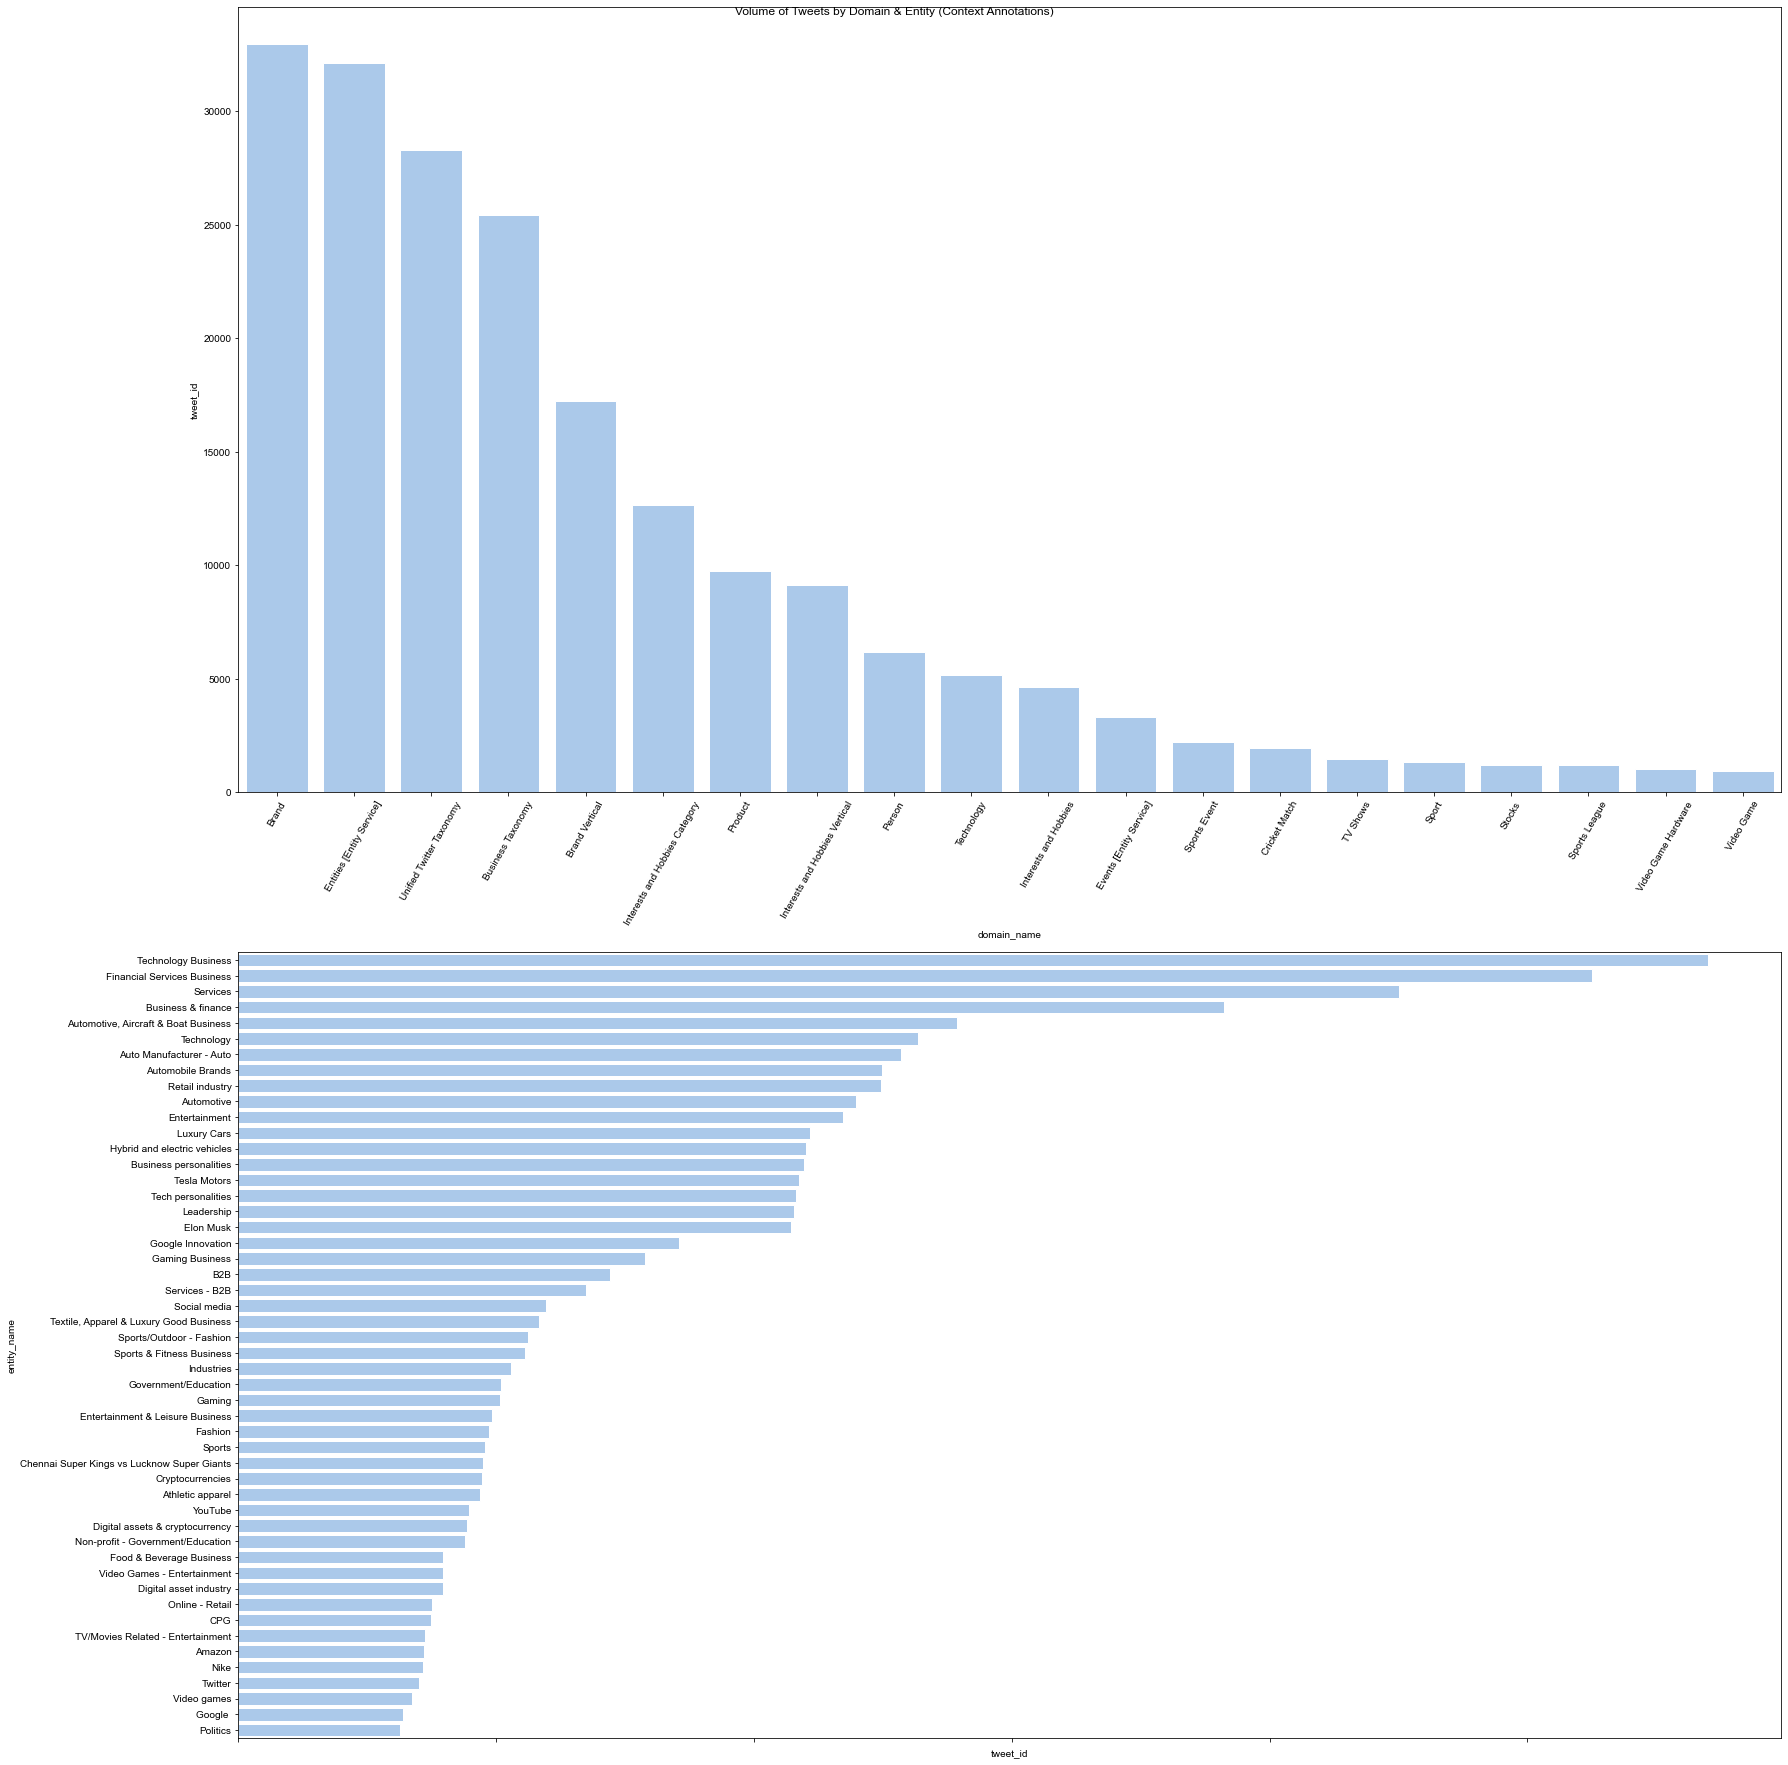

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, figsize = (25, 25))
fig.suptitle('Volume of Tweets by Domain & Entity (Context Annotations)')

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(ax=axs[0], x=top_20_domain_counts['domain_name'], y=top_20_domain_counts['tweet_id'], color="b")
sns.barplot(ax=axs[1], x=top_50_entity_counts['tweet_id'], y=top_50_entity_counts['entity_name'], color="b", orient='h')

# sns.despine(left=True, bottom=True)
# Rotate the x-axis labels
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=60)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60)

plt.tight_layout()  # Adjust spacing to avoid label overlap

plt.show()

In [ ]:
##WHAT IS THE DISTRIBUTION OF FOLLOWER COUNT FOR ALL USERS
##WHAT IS THE DISTRIBUTION OF FOLLOWING-FOLLWOING RATION FOR ALL USERS
##DO SOME ANALYSIS USING NTLK ON EACH USER'S BIO 

In [ ]:
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

In [ ]:
def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def countEmoticons(text):
    """ Input: a text, Output: how many emoticons """
    return len(re.findall(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', text))


In [ ]:
import string
import nltk
nltk.download('stopwords')

""" Tokenizes a text to its words, removes and replaces some of them """    
finalTokens = [] # all tokens
stoplist = stopwords.words('english')
my_stopwords = "multiexclamation multiquestion multistop url atuser st rd nd th am pm" # my extra stopwords
stoplist = stoplist + my_stopwords.split()
allowedWordTypes = ["J","R","V","N"] #  J is Adject, R is Adverb, V is Verb, N is Noun. These are used for POS Tagging
# lemmatizer = WordNetLemmatizer() # set lemmatizer
# stemmer = PorterStemmer() # set stemmer

# Create a DataFrame to store the preprocessed text and tweet ID
preprocessed_data = pd.DataFrame(columns=['tweet_id', 'text'])

In [ ]:
def tokenize(text, wordCountBefore, tweet_id):
    totalAdjectives = 0
    totalAdverbs = 0
    totalVerbs = 0
    onlyOneSentenceTokens = []  # tokens of one sentence each time

    tokens = nltk.word_tokenize(text)

    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)  # Technique 7: remove punctuation

    tokens = nltk.word_tokenize(text)

    tagged = nltk.pos_tag(tokens)  # Technique 13: part of speech tagging
    for w in tagged:
        if w[1][0] in allowedWordTypes and w[0] not in stoplist:
            onlyOneSentenceTokens.append(w[0])
            finalTokens.append(w[0])

    onlyOneSentence = " ".join(onlyOneSentenceTokens)

    # Store the preprocessed text and tweet ID in the DataFrame
    preprocessed_data.loc[len(preprocessed_data)] = [tweet_id, onlyOneSentence]

    return finalTokens

In [ ]:
from time import time
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Retrieve all tweets from the database
query = "SELECT DISTINCT * FROM tweets"
df_tweets = pd.read_sql_query(query, conn)
#Tweet_id is column 0, text is column 3


t0 = time()
totalSentences = 0
totalEmoticons = 0
totalSlangs = 0
totalSlangsFound = []
totalElongated = 0
totalMultiExclamationMarks = 0
totalMultiQuestionMarks = 0
totalMultiStopMarks = 0
totalAllCaps = 0

# Iterate over each row in df_tweets
for index, row in df_tweets.iterrows():
    totalSentences += 1
    feat = []

    tweet_id = row['tweet_id']
    text     = removeUnicode(row['text'])  # Technique 0

    wordCountBefore = len(re.findall(r'\w+', text))  # word count of one sentence before preprocess

    emoticons = countEmoticons(text)  # how many emoticons in this sentence
    totalEmoticons += emoticons

    text = removeEmoticons(text)  # removes emoticons from text
    tokens = tokenize(text, wordCountBefore, tweet_id)  

    print("Processed tweet:", tweet_id)  # Print the tweet ID after processing

# View the resulting preprocessed data
print(preprocessed_data.head())
    
print("Total sentences: ",totalSentences,"\n")
print("Total Words before preprocess: ",len(re.findall(r'\w+', f)))
print("Total Distinct Tokens before preprocess: ",len(set(re.findall(r'\w+', f))))
print("Average word/sentence before preprocess: ",len(re.findall(r'\w+', f))/totalSentences,"\n")
print("Total Words after preprocess: ",len(tokens))
print("Total Distinct Tokens after preprocess: ",len(set(tokens)))
print("Average word/sentence after preprocess: ",len(tokens)/totalSentences,"\n")


print("Total run time: ",time() - t0," seconds\n")

print("Total emoticons: ",totalEmoticons,"\n")
print("Total slangs: ",totalSlangs,"\n")
commonSlangs = nltk.FreqDist(totalSlangsFound)
for (word, count) in commonSlangs.most_common(20): # most common slangs across all texts
    print(word,"\t",count)

commonSlangs.plot(20, cumulative=False) # plot most common slangs

print("Total elongated words: ",totalElongated,"\n")
print("Total multi exclamation marks: ",totalMultiExclamationMarks)
print("Total multi question marks: ",totalMultiQuestionMarks)
print("Total multi stop marks: ",totalMultiStopMarks,"\n")
print("Total all capitalized words: ",totalAllCaps,"\n")

#print(tokens)
commonWords = nltk.FreqDist(tokens)
print("Most common words ")
print("Word\tCount")
for (word, count) in commonWords.most_common(100): # most common words across all texts
    print(word,"\t",count)

commonWords.plot(100, cumulative=False) # plot most common words


bgm = nltk.collocations.BigramAssocMeasures()
tgm = nltk.collocations.TrigramAssocMeasures()
bgm_finder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
tgm_finder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
bgm_finder.apply_freq_filter(5) # bigrams that occur at least 5 times
print("Most common collocations (bigrams)")
print(bgm_finder.nbest(bgm.pmi, 50)) # top 50 bigram collocations
tgm_finder.apply_freq_filter(5) # trigrams that occur at least 5 times
print("Most common collocations (trigrams)")
print(tgm_finder.nbest(tgm.pmi, 20)) # top 20 trigrams collocations